In [38]:
import matplotlib.pyplot as plt
import plot_utils as u
import csv
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns

In [39]:
dir = Path('Zero_MPI_comparison/4s-new/')

In [40]:
res_dirs = [d for d in dir.iterdir() if d.is_dir()]
res_dirs.sort(key=lambda s: int(s.name.split('_mpi')[-1]))
num_results = len(res_dirs)

ZeroController-20221222123015_mpi10:
	LFP mean: -9.652163126891605e-05, var: 7.221587198461746e-07
	beta mean: 0.0001802677546680941, beta var: 7.501179445924478e-09
	beta' mean: -8.438977384523626e-09, var: 5.579823969424138e-10
ZeroController-20221222133016_mpi10:
	LFP mean: -8.809585425273e-05, var: 7.088025545030437e-07
	beta mean: 0.00017515318421900634, beta var: 8.246142873227374e-09
	beta' mean: -1.1141899436345841e-07, var: 5.112967175860232e-10
ZeroController-20221222133116_mpi10:
	LFP mean: -9.180380327163392e-05, var: 7.144796508370889e-07
	beta mean: 0.0001798160727823492, beta var: 8.63929246220149e-09
	beta' mean: -1.5472727883343726e-07, var: 5.712831127738309e-10
ZeroController-20221222123115_mpi12:
	LFP mean: -9.218543516016868e-05, var: 7.13464803760785e-07
	beta mean: 0.00017088356080469992, beta var: 7.327257278779133e-09
	beta' mean: -8.415096025912137e-08, var: 5.66018141645511e-10
ZeroController-20221222133016_mpi12:
	LFP mean: -7.612667713877823e-05, var: 7.344

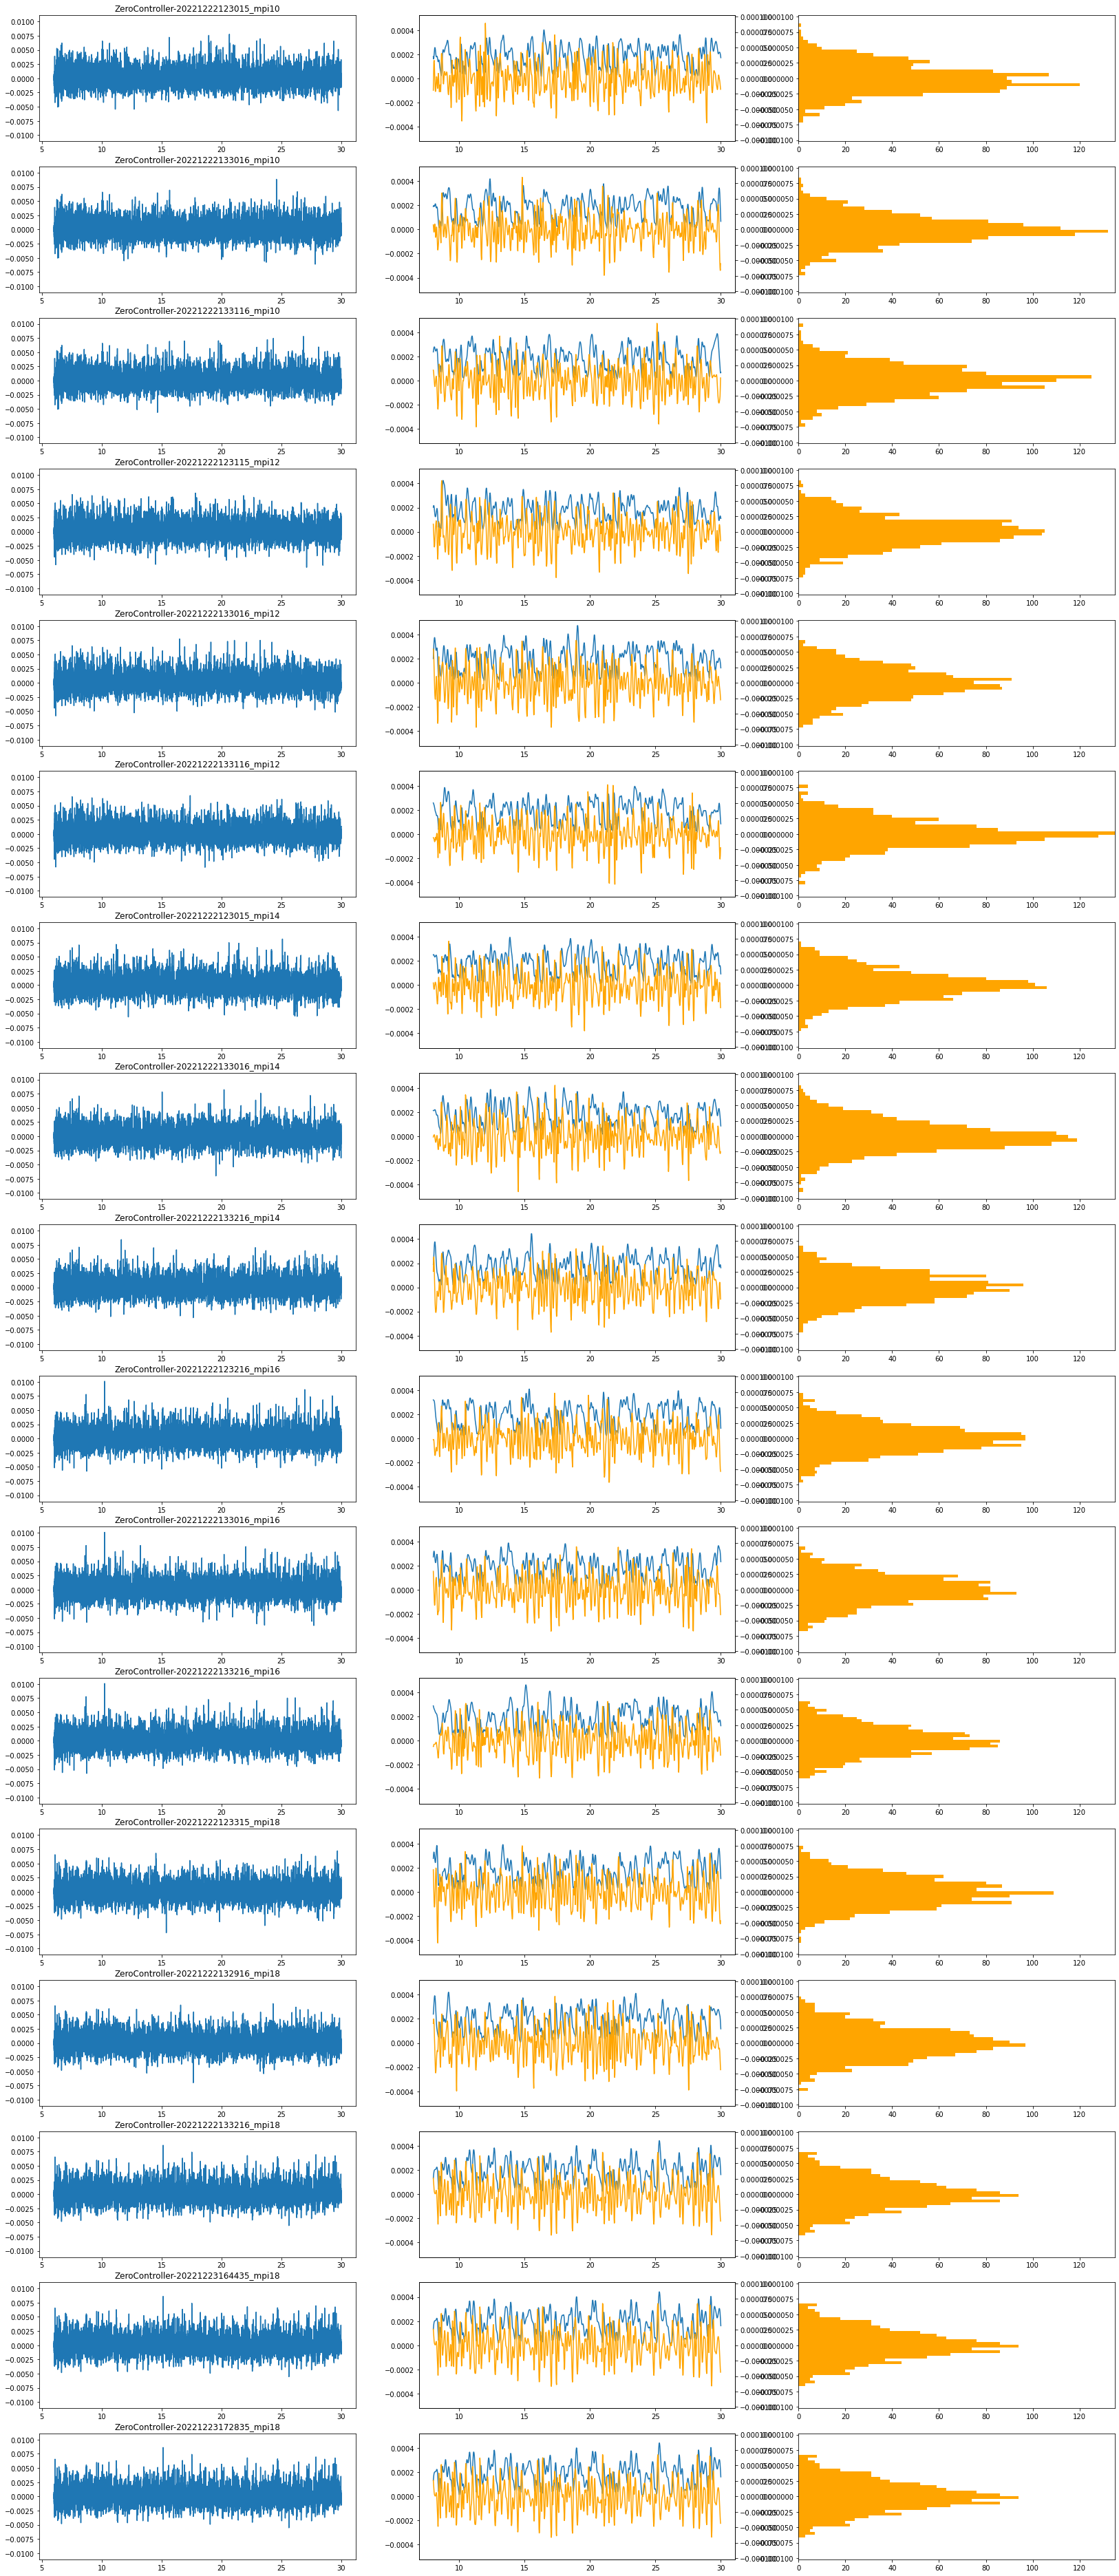

In [41]:
fig, axs = plt.subplots(num_results, 3, figsize=(28, num_results * 4))
axs_diff = []
range_diff = 0
range_lfp = 0
range_beta = 0
range_hist = 0

quant = {
    "threads": [],
    "LFP mean": [],
    "LFP var": [],
    "beta mean": [],
    "beta var": [],
    "dbeta mean": [],
    "dbeta var": []
}

for i, d in enumerate(res_dirs):
    controller_t, _, controller_beta = u.load_controller_data(d, None)
    time_max = controller_t[-1] * 1000
    tt, rec = u.load_stn_lfp(d, 6000, time_max)
    if num_results > 1:
        axs[i, 0].plot(tt / 1000, rec['signal'])
        axs[i, 0].set_title(d.name)
        axs[i, 1].plot(controller_t, controller_beta)
    else:
        axs[0].plot(tt / 1000, rec['signal'])
        axs[0].set_title(d.name)
        axs[1].plot(controller_t, controller_beta)
    diff_beta = np.diff(controller_beta)
    if np.max(np.abs(diff_beta)) > range_diff:
        range_diff = np.max(np.abs(diff_beta))
    if np.max(np.abs(rec['signal'])) > range_lfp:
        range_lfp = np.max(np.abs(rec['signal']))
    if np.max(np.abs(controller_beta)) > range_beta:
        range_beta = np.max(np.abs(controller_beta))
    if num_results > 1:
        ax2 = axs[i, 1].twinx()
    else:
        ax2 = axs[1].twinx()
    axs_diff.append(ax2)
    ax2.plot(controller_t[:-1], diff_beta, color='orange')
    if num_results > 1:
        h = axs[i, 2].hist(diff_beta, bins=30, color='orange', orientation='horizontal')
    else:
        h = axs[2].hist(diff_beta, bins=30, color='orange', orientation='horizontal')
    if h[0].max() > range_hist:
        range_hist = h[0].max()
    print(f"{d.name}:\n\tLFP mean: {rec['signal'].mean()}, var: {rec['signal'].var()}\n"
          f"\tbeta mean: {controller_beta.mean()}, beta var: {controller_beta.var()}\n"
          f"\tbeta' mean: {diff_beta.mean()}, var: {diff_beta.var()}")
    quant["threads"].append(int(d.name.split("_mpi")[-1]))
    quant["LFP mean"].append(rec['signal'].mean())
    quant["LFP var"].append(rec['signal'].var())
    quant["beta mean"].append(controller_beta.mean())
    quant["beta var"].append(controller_beta.var())
    quant["dbeta mean"].append(diff_beta.mean())
    quant["dbeta var"].append(diff_beta.var())
    
    
range_diff *= 1.1
range_lfp *= 1.1
range_beta *= 1.1
for i, ax in enumerate(axs_diff):
    ax.set_ylim([-range_diff, range_diff])
    if num_results > 1:
        axs[i, 2].set_ylim([-range_diff, range_diff])
        axs[i, 2].set_xlim([0, range_hist])
        axs[i, 1].set_ylim([-range_beta, range_beta])
        axs[i, 0].set_ylim([-range_lfp, range_lfp])
    else:
        axs[2].set_ylim([-range_diff, range_diff])
        axs[2].set_xlim([0, range_hist])
        axs[1].set_ylim([-range_beta, range_beta])
        axs[0].set_ylim([-range_lfp, range_lfp])

In [42]:
df = pd.DataFrame(quant)

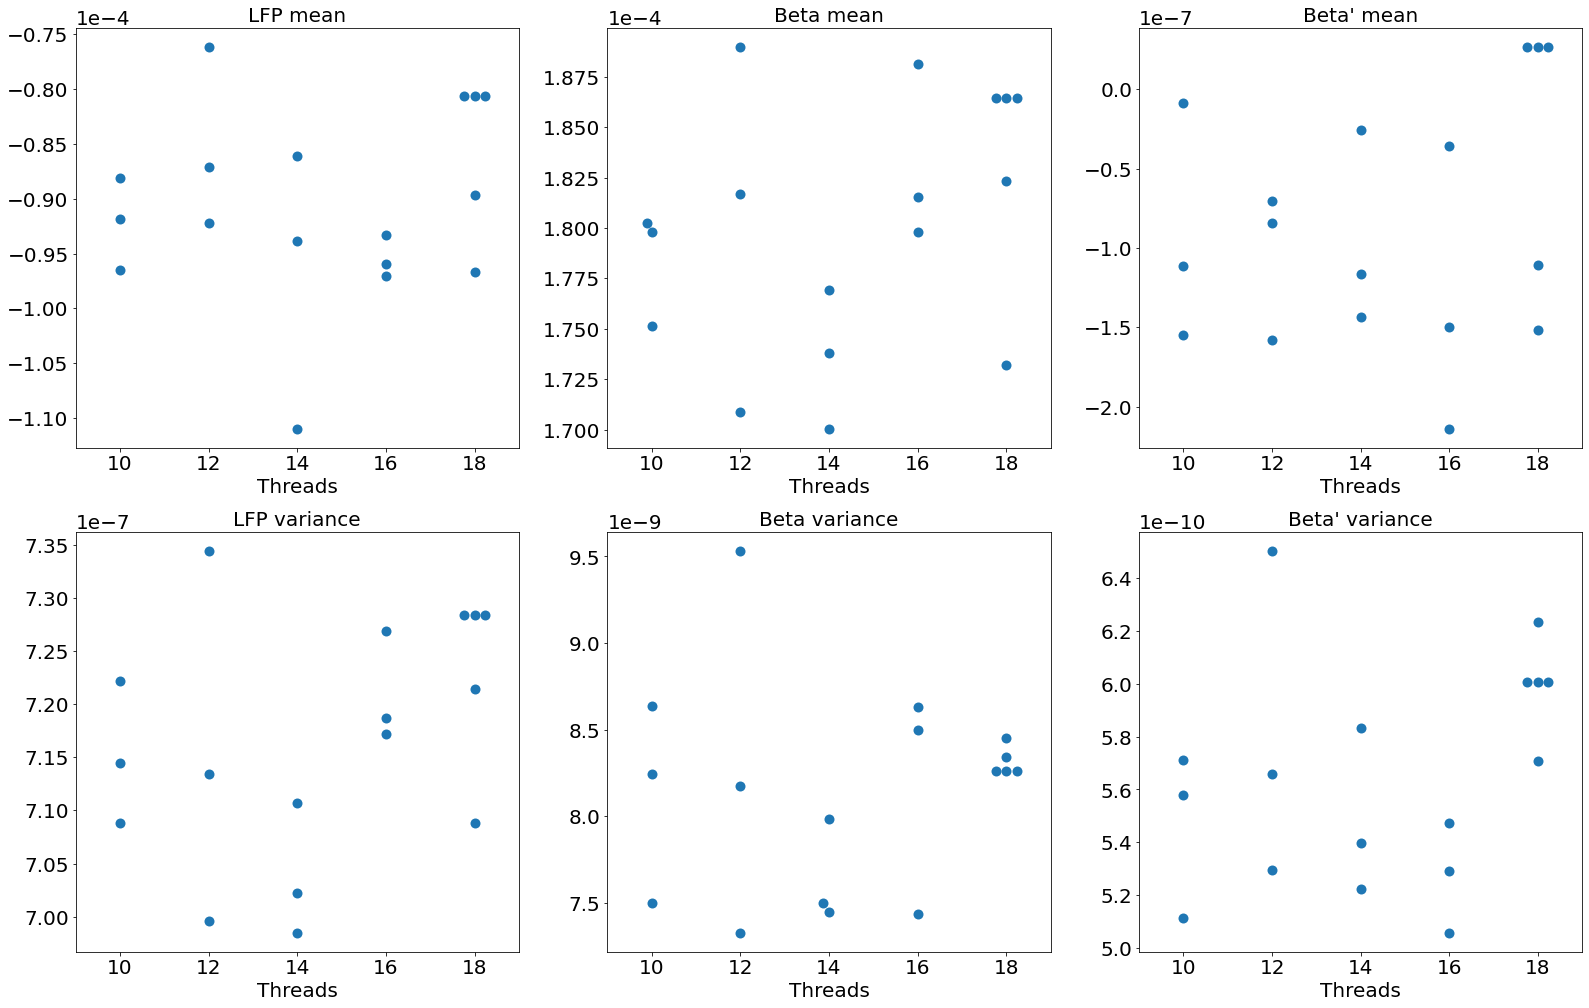

In [43]:
markersize = 10
fontsize = 20
fig, axs = plt.subplots(2, 3, figsize=(27, 17))

sns.swarmplot(df, x="threads", y="LFP mean", ax=axs[0, 0], size=markersize)
axs[0, 0].set_title("LFP mean", fontsize=fontsize)
sns.swarmplot(df, x="threads", y="LFP var", ax=axs[1, 0], size=markersize)
axs[1, 0].set_title("LFP variance", fontsize=fontsize)
sns.swarmplot(df, x="threads", y="beta mean", ax=axs[0, 1], size=markersize)
axs[0, 1].set_title("Beta mean", fontsize=fontsize)
sns.swarmplot(df, x="threads", y="beta var", ax=axs[1, 1], size=markersize)
axs[1, 1].set_title("Beta variance", fontsize=fontsize)
sns.swarmplot(df, x="threads", y="dbeta mean", ax=axs[0, 2], size=markersize)
axs[0, 2].set_title("Beta' mean", fontsize=fontsize)
sns.swarmplot(df, x="threads", y="dbeta var", ax=axs[1, 2], size=markersize)
axs[1, 2].set_title("Beta' variance", fontsize=fontsize)

for row in axs:
    for a in row:
        plt.setp(a.get_xticklabels(), fontsize=fontsize)
        plt.setp(a.get_yticklabels(), fontsize=fontsize)
        a.set_xlabel("Threads", fontsize=fontsize)
        a.yaxis.offsetText.set_fontsize(fontsize)
        a.ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
        a.set_ylabel(None)

plt.savefig("signal_params.png", bbox_inches='tight', facecolor='white')
